# Natural Language Processing

This dataset was collected from Twitter. The social media platform has become a place for many things, including emergency notifications and news updates on  disaters. We are answering the question: How can we filter tweets to achieve only ones that are related to  disasters? The vernacular of the social media generations uses words like, "fire," and, "the bomb," to describe things as good or amazing, and those are tweets we do not want to filter into our search of disasters. We will build five models and one model that stacks all five.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import string
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix, hstack
import nltk
from collections import defaultdict
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop=set(stopwords.words('english'))
import string
from collections import  Counter
special=string.punctuation
import re
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austinguard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/austinguard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/austinguard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
twitter=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
print('%s rows and %s columns\n' % (twitter.shape[0],twitter.shape[1]))
print('Unique values:')
print(twitter.nunique())
twitter.head()

7613 rows and 5 columns

Unique values:
id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
np.random.seed(123)
random_real_tweets = twitter[twitter['target']==1]['text'].sample(5).values
random_fake_tweets = twitter[twitter['target']==0]['text'].sample(5).values
print('Disaster tweets:\n')
for i, tweet in enumerate(random_real_tweets):
    print('[{0}] {1}\n'.format(i+1, tweet))
    if i == 5:
        break

print('-'*90)
print('Non-Disaster tweets:\n')
for i, tweet in enumerate(random_fake_tweets):
    print('[{0}] {1}\n'.format(i+1, tweet))
    if i == 5:
        break

Disaster tweets:

[1] Û÷Hijacker copsÛª back in the dock - http://t.co/9I5cczD5S0 http://t.co/WEaTrRihE1

[2] Buildings are on fire and they have time for a business meeting #TheStrain

[3] @SwellyJetEvo Disneyland! Tacos there are bomb!

[4] Some of worst radiation exposure from Fukushima meltdown happened 47km northwest-Proof that small emergency planning zones donÛªt cut it

[5] We're #hiring! Click to apply: RN II/EMERGENCY SERVICES/FT/7P-7A - http://t.co/NV3Uxv9IMX #Nursing #Houston TX http://t.co/ej30IhrEA9

------------------------------------------------------------------------------------------
Non-Disaster tweets:

[1] Eating takis then rubbing my eyes with my hands now my eyes are bleeding tears

[2] @LibertarianLuke I'm all for that to be honest. If people want to go on a rampage let them use their own hands and feet. No casualties.

[3] @SeanPeconi @Jason_Floyd @LynchOnSports @criscyborg I think the risk of losing and getting her nose flattened has a lot to do with it



This data is not clean. There are many missing keywords, locations, and the tweet is filled with unnecessary punctuation like @ and # and URLs. Below we will look at basic statistics for the data. 

<AxesSubplot:xlabel='target', ylabel='count'>

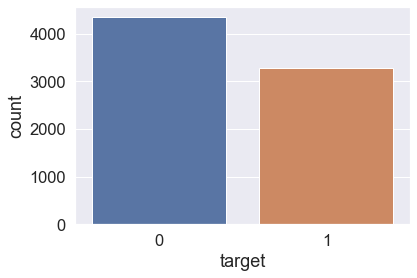

In [4]:
sns.set(rc={'figure.figsize':(6,6),'axes.labelsize':12})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.countplot(twitter.target)

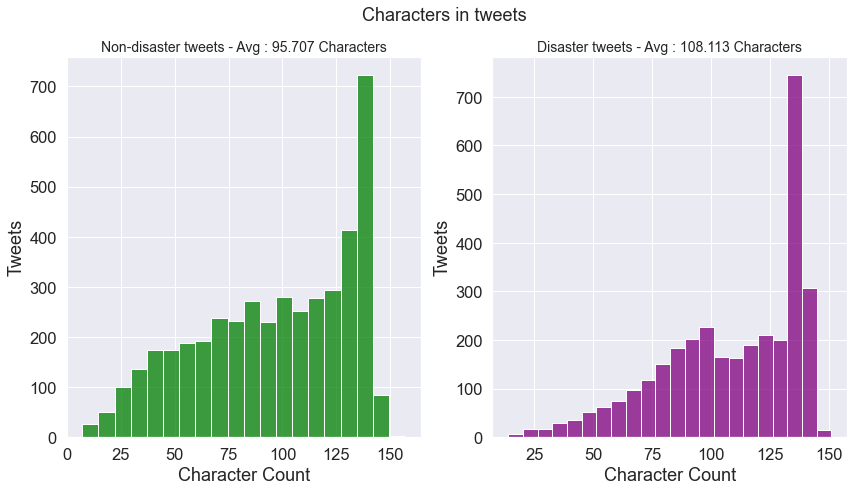

In [5]:
twitter['textLen']=twitter['text'].apply(len)
test['textLen']=test['text'].apply(len)
t0=twitter[twitter['target']==0]['textLen']
t1=twitter[twitter['target']==1]['textLen']
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,7))
sns.histplot(t0, discrete=False, color='green',ax=ax1)
sns.histplot(t1, discrete=False, color='purple',ax=ax2)
ax1.set_xlabel('Character Count')
ax2.set_xlabel('Character Count')
ax1.set_ylabel('Tweets')
ax2.set_ylabel('Tweets')
ax1.set_title('Non-disaster tweets - Avg : %.3f Characters' % np.mean(t0),fontsize=14)
ax2.set_title('Disaster tweets - Avg : %.3f Characters' % np.mean(t1),fontsize=14)
fig.suptitle('Characters in tweets', fontsize=18)
plt.show()

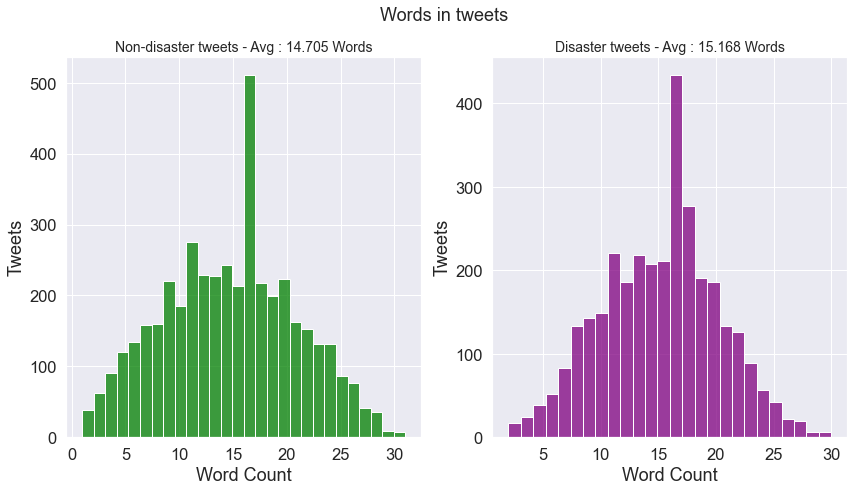

In [6]:
t0=twitter[twitter['target']==0]['text'].str.split().map(lambda x: len(x))
t1=twitter[twitter['target']==1]['text'].str.split().map(lambda x: len(x))
twitter['word_count']=twitter['text'].str.split().map(lambda x: len(x))
test['word_count']=test['text'].str.split().map(lambda x: len(x))
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,7))
sns.histplot(t0, discrete=False, color='green',ax=ax1)
sns.histplot(t1, discrete=False, color='purple',ax=ax2)
ax1.set_xlabel('Word Count')
ax2.set_xlabel('Word Count')
ax1.set_ylabel('Tweets')
ax2.set_ylabel('Tweets')
ax1.set_title('Non-disaster tweets - Avg : %.3f Words' % np.mean(t0), fontsize=14)
ax2.set_title('Disaster tweets - Avg : %.3f Words' % np.mean(t1), fontsize=14)
fig.suptitle('Words in tweets', fontsize=18)
plt.show()

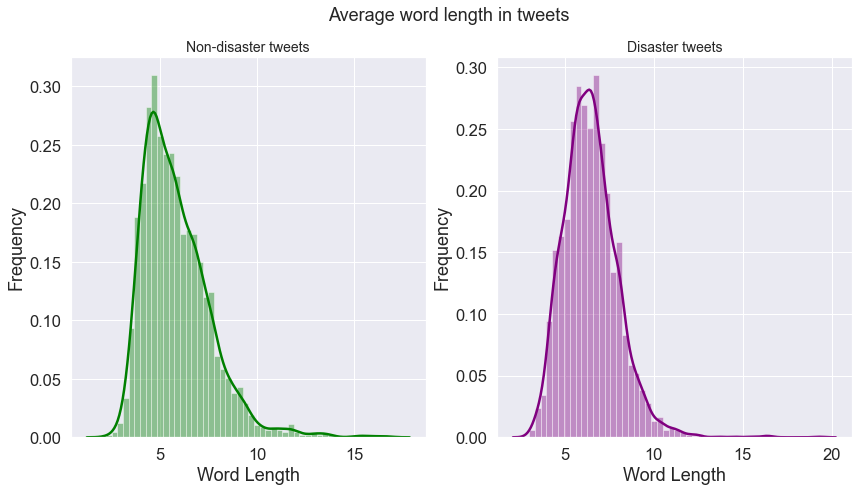

In [7]:
t0=twitter[twitter['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
t1=twitter[twitter['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,7))
sns.distplot(t0.map(lambda x: np.mean(x)),ax=ax1,color='green')
sns.distplot(t1.map(lambda x: np.mean(x)),ax=ax2,color='purple')
ax1.set_xlabel('Word Length')
ax2.set_xlabel('Word Length')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')
ax1.set_title('Non-disaster tweets', fontsize=14)
ax2.set_title('Disaster tweets', fontsize=14)
fig.suptitle('Average word length in tweets', fontsize=18)
plt.show()

In [8]:
def word_list(target):
    word=[]
    
    for x in twitter[twitter['target']==target]['text'].str.split():
        for i in x:
            word.append(i)
   
    return word

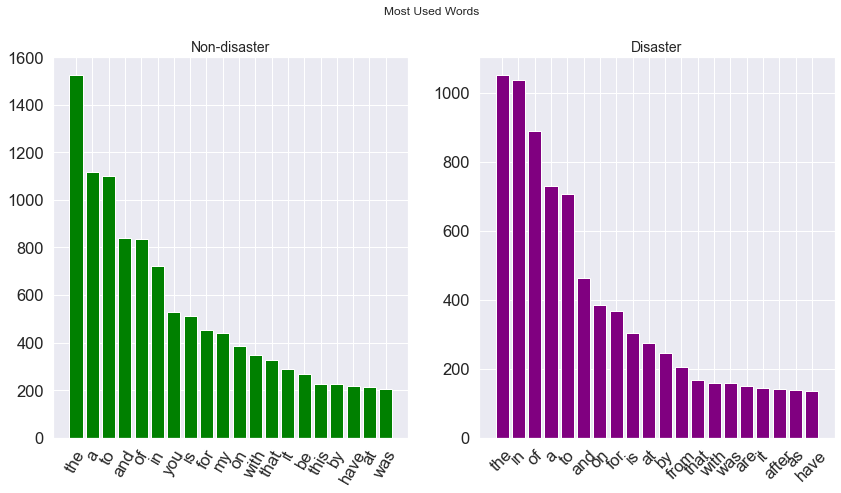

In [9]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,7))
word=word_list(0)
dic=defaultdict(int)
for i in word:
    if i in stop:
        dic[i]+=1
top=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:20]
x,y=zip(*top)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
ax1.bar(x,y,color='green')
ax1.tick_params('x',rotation=60)
ax1.set_title('Non-disaster',fontsize=14)
word=word_list(1)
dic=defaultdict(int)
for i in word:
    if i in stop:
        dic[i]+=1
top=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:20]
x,y=zip(*top)
plt.rc('xtick', labelsize=12)
ax2.tick_params('x',rotation=45)
plt.rc('ytick', labelsize=12)
ax2.bar(x,y,color='purple')
ax2.set_title('Disaster',fontsize=14)
fig.suptitle('Most Used Words')
plt.show()

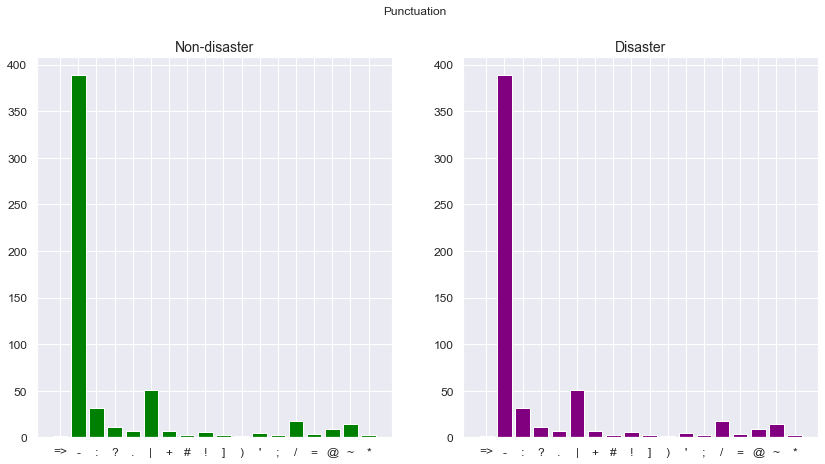

In [10]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,7))
punct=word_list(0)
dic=defaultdict(int)
for i in word:
    if i in special:
        dic[i]+=1
x,y=zip(*dic.items())
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
ax1.bar(x,y,color='green')
ax1.set_title('Non-disaster',fontsize=14)
punct=word_list(1)
dic=defaultdict(int)
for i in word:
    if i in special:
        dic[i]+=1
x,y=zip(*dic.items())
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
ax2.bar(x,y,color='purple')
ax2.set_title('Disaster',fontsize=14)
fig.suptitle('Punctuation')
plt.show()

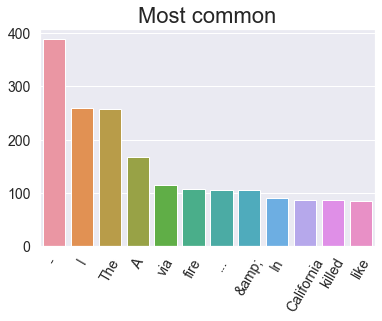

In [11]:
counter=Counter(punct)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=x,y=y)
plt.xticks(rotation=60)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=18)
plt.title('Most common',fontsize=22)
plt.show()

It looks like "fire" is one of the most common words in our dataset. "Killed" is another popular word to use in young persons slang.

In [12]:
def check_digits(text):
    if [char for char in text if char in string.digits]:
        return 1
    else:
        return 0
    
def check_punctation(text):
    if [char for char in text if char in string.punctuation]:
        return 1
    else:
        return 0
    
def count_punctation(text):
    count = 0
    for char in text:
        if char in string.punctuation:    
            count +=1
    return count

def count_digits(text):
    count = 0
    for char in text:
        if char in string.digits:    
            count +=1
    return count

twitter['check_digits'] = twitter['text'].apply(lambda x: check_digits(x))
test['check_digits'] = test['text'].apply(lambda x: check_digits(x))
twitter['check_punctation'] = twitter['text'].apply(lambda x: check_punctation(x))
test['check_punctation'] = test['text'].apply(lambda x: check_punctation(x))
twitter['count_punctation'] = twitter['text'].apply(lambda x: count_punctation(x))
test['count_punctation'] = test['text'].apply(lambda x: count_punctation(x))
twitter['count_digits'] = twitter['text'].apply(lambda x: count_digits(x))
test['count_digits'] = test['text'].apply(lambda x: count_digits(x))
twitter['check_http'] = twitter['text'].str.contains('http')
test['check_http'] = test['text'].str.contains('http')
twitter['check_hash'] = twitter['text'].str.contains('#')
test['check_hash'] = test['text'].str.contains('#')
twitter.head()

,id,keyword,location,text,target,textLen,word_count,check_digits,check_punctation,count_punctation,count_digits,check_http,check_hash
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,0,1,1,0,False,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,0,1,1,0,False,False
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,0,1,3,0,False,False
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1,1,2,5,False,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,0,1,2,0,False,True


In [13]:
def clean_text(text):
    stop_words = stopwords.words('english')
    stop_words.append('i\'m')
    text = text.lower()
    text = ' '.join([char for char in text.split() if char not in stop_words])
    text = ' '.join(['' if 'http' in char else char for char in text.split()])
    text = ''.join([char+' ' if char in string.punctuation else char for char in text ])
    text = ''.join([char for char in text if char in string.ascii_lowercase or char in ' ' or  char in string.digits])
    text = ' '.join(text.split())
    return text

In [14]:
#check if it works
for i, text in enumerate(twitter.text.head()):
    print(f'Clean [{i+1}]:', clean_text(text), end='\n\n')
    print(f'Real [{i+1}]:', text, end='\n\n')
    print()

Clean [1]: deeds reason earthquake may allah forgive us

Real [1]: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


Clean [2]: forest fire near la ronge sask canada

Real [2]: Forest fire near La Ronge Sask. Canada


Clean [3]: residents asked shelter place notified officers evacuation shelter place orders expected

Real [3]: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected


Clean [4]: 13 000 people receive wildfires evacuation orders california

Real [4]: 13,000 people receive #wildfires evacuation orders in California 


Clean [5]: got sent photo ruby alaska smoke wildfires pours school

Real [5]: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 




We have broken each tweet down to it's bare form, removing any symbols and stop words. This form is distilled down to the unique words. This will help our models analyze the messages quicker.

In [15]:
twitter['cleanText']=twitter['text'].apply(clean_text)
test['cleanText']=test['text'].apply(clean_text)
twitter.head().T

,0,1,2,3,4
id,1,4,5,6,7
keyword,NaN,NaN,NaN,NaN,NaN
location,NaN,NaN,NaN,NaN,NaN
text,Our Deeds are the Reason of this #earthquake M...,Forest fire near La Ronge Sask. Canada,All residents asked to 'shelter in place' are ...,"13,000 people receive #wildfires evacuation or...",Just got sent this photo from Ruby #Alaska as ...
target,1,1,1,1,1
textLen,69,38,133,65,88
word_count,13,7,22,8,16
check_digits,0,0,0,1,0
check_punctation,1,1,1,1,1
count_punctation,1,1,3,2,2


We will go through one last round of cleaning, making sure locations and keywords are not null.

In [16]:
twitter['keyword'].isnull().sum()

61

In [17]:
twitter['keyword']=twitter['keyword'].fillna('Empty')
test['keyword']=test['keyword'].fillna('Empty')
twitter['keyword'].nunique()

222

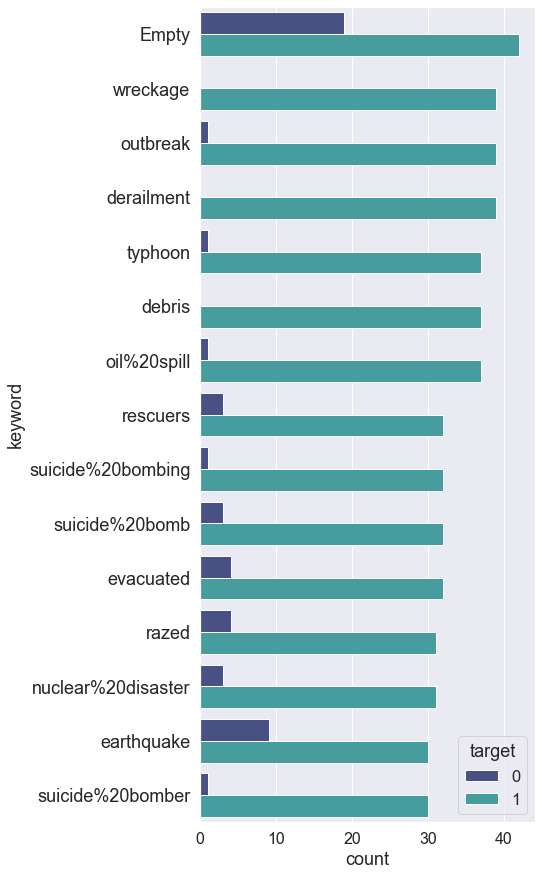

In [18]:
plt.figure(figsize=(6,15))
sns.countplot(data=twitter, y='keyword', hue='target',
              order=twitter[twitter['target'] == 1]['keyword'].value_counts().head(15).index,
             palette='mako');

In [19]:
print('Null Locations: ',twitter['location'].isnull().sum())

Null Locations:  2533


In [20]:
cleanedTwitter = twitter.drop(['count_digits','count_punctation','id','location', 'text'], axis=1)
test = test.drop(['count_digits','count_punctation','location', 'text'], axis=1)
cleanedTwitter.head()

,keyword,target,textLen,word_count,check_digits,check_punctation,check_http,check_hash,cleanText
0,Empty,1,69,13,0,1,False,True,deeds reason earthquake may allah forgive us
1,Empty,1,38,7,0,1,False,False,forest fire near la ronge sask canada
2,Empty,1,133,22,0,1,False,False,residents asked shelter place notified officer...
3,Empty,1,65,8,1,1,False,True,13 000 people receive wildfires evacuation ord...
4,Empty,1,88,16,0,1,False,True,got sent photo ruby alaska smoke wildfires pou...


In [21]:
cleanedTwitter['check_http'] = cleanedTwitter['check_http'].apply(lambda x: 1 if x else 0)
test['check_http'] = test['check_http'].apply(lambda x: 1 if x else 0)
cleanedTwitter['check_hash'] = cleanedTwitter['check_hash'].apply(lambda x: 1 if x else 0)
test['check_hash'] = test['check_hash'].apply(lambda x: 1 if x else 0)

In [22]:
sc = MinMaxScaler()
sc.fit(cleanedTwitter['textLen'].values.reshape(-1,1))
cleanedTwitter['textLen'] = sc.transform(cleanedTwitter['textLen'].values.reshape(-1,1))
test['textLen'] = sc.transform(test['textLen'].values.reshape(-1,1))

In [23]:
cleanedTwitter['cleanText'] = cleanedTwitter['cleanText'].apply(lambda x: nltk.tokenize.word_tokenize(x))
test['cleanText'] = test['cleanText'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [24]:
print('Before: ', twitter['cleanText'][5])
print('After: ', cleanedTwitter['cleanText'][5])

Before:  rockyfire update california hwy 20 closed directions due lake county fire cafire wildfires
After:  ['rockyfire', 'update', 'california', 'hwy', '20', 'closed', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfires']


In [25]:
def lem_word(text):
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]
    return text
cleanedTwitter['cleanText'] = cleanedTwitter['cleanText'].apply(lem_word)
test['cleanText'] = test['cleanText'].apply(lem_word)
print('Before: ', twitter['cleanText'][16])
print('After: ', cleanedTwitter['cleanText'][16])

Before:  love fruits
After:  ['love', 'fruit']


In [26]:
target=cleanedTwitter['target']
cleanedTwitter=cleanedTwitter.drop(['target'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(cleanedTwitter,target, 
                                                    test_size=.2, random_state=123)

In [27]:
X_train['cleanText'] = X_train['cleanText'].apply(lambda x: ' '.join(x))
X_test['cleanText'] = X_test['cleanText'].apply(lambda x: ' '.join(x))
test['cleanText'] = test['cleanText'].apply(lambda x: ' '.join(x))
tfid = TfidfVectorizer()
X_train_tfid_text = tfid.fit_transform(X_train['cleanText'])
X_test_tfid_text = tfid.transform(X_test['cleanText'])
test_text = tfid.transform(test['cleanText'])
X_train_tfid_keyword = tfid.fit_transform(X_train['keyword'])
X_test_tfid_keyword = tfid.transform(X_test['keyword'])
test_keyword = tfid.transform(test['keyword'])
X_train_tfid = hstack([X_train_tfid_text, X_train_tfid_keyword])
X_test_tfid = hstack([X_test_tfid_text, X_test_tfid_keyword])
TEST = hstack([test_text, test_keyword])

We will look at different logistic models and look at the precision/recall rates and F1 scores. We are looking for models with higher recall than precision.

In [28]:
clf=[MultinomialNB(fit_prior=False),LogisticRegression(C=10 ,max_iter=1000),
            SVC(kernel='linear'),SGDClassifier(alpha=5e-4, random_state=123),
             SGDClassifier(loss='log_loss', alpha=5e-05, random_state=123)]
for estimator in clf:
    acc = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    prec = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='precision', n_jobs=-1)
    rec = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='recall', n_jobs=-1)
    f1 = cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    print(estimator,'\n--------------------------------')
    print('ACCURACY:', np.mean(acc))
    print('PRECISION:', np.mean(prec))
    print('RECALL:', np.mean(rec))
    print('\nMain metric:', '\n--------------------------------', sep='')
    print('F1:', np.mean(f1))
    print('--------------------------------\n')



MultinomialNB(fit_prior=False) 
--------------------------------
ACCURACY: 0.7738916256157635
PRECISION: 0.7351731289991341
RECALL: 0.746101326375299

Main metric:
--------------------------------
F1: 0.7401409520415134
--------------------------------

LogisticRegression(C=10, max_iter=1000) 
--------------------------------
ACCURACY: 0.7791461412151067
PRECISION: 0.7689358508748824
RECALL: 0.6996612307023266

Main metric:
--------------------------------
F1: 0.7321339009330892
--------------------------------

SVC(kernel='linear') 
--------------------------------
ACCURACY: 0.7886699507389162
PRECISION: 0.7866500437272722
RECALL: 0.7015646879756469

Main metric:
--------------------------------
F1: 0.741103497468932
--------------------------------

SGDClassifier(alpha=0.0005, random_state=123) 
--------------------------------
ACCURACY: 0.7816091954022988
PRECISION: 0.7852895725631105
RECALL: 0.6813903022396174

Main metric:
--------------------------------
F1: 0.7290431446659259
--

In [29]:
def save_main_metric(estimator):
    f1 = np.mean(cross_val_score(estimator, X_train_tfid, y_train, cv=3, scoring='f1', n_jobs=-1))
    final_scores.append(f1)

In [30]:
stacking_estimators = [('svc', clf[2]), ('nb', clf[0]), ('sgd_svm', clf[3]), ('sgd_log', clf[4])]
stacking = StackingClassifier(stacking_estimators, clf[1], cv=5, n_jobs=-1)

In [31]:
final_scores = []
name_model = ['Multinomial NB','Logistic Regression','SVM','SGD SVM', 'SGD Logit', 'Stacking model']
all_model = [clf[0],clf[1],clf[2],clf[3],clf[4], stacking]
for model in all_model:
    f1 = np.mean(cross_val_score(model, X_train_tfid, y_train, cv=3, scoring='f1', n_jobs=-1))
    final_scores.append(f1)

In [32]:
resultsDF=pd.DataFrame(final_scores, index=name_model, columns=['F1 Score'])
resultsDF

,F1 Score
Multinomial NB,0.740141
Logistic Regression,0.732134
SVM,0.741103
SGD SVM,0.729043
SGD Logit,0.737131
Stacking model,0.745009


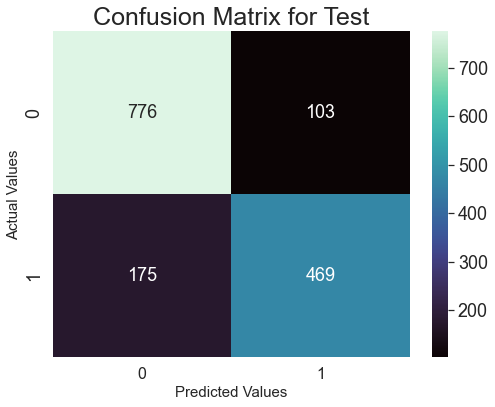

In [33]:
stacking.fit(X_train_tfid, y_train)
y_pred=stacking.predict(X_test_tfid)
plt.figure(figsize=(8,6))
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,cmap='mako',fmt='.4g',annot=True, annot_kws={'fontsize':18})
plt.title('Confusion Matrix for Test', fontsize=25);
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Actual Values', fontsize=15);
plt.show()

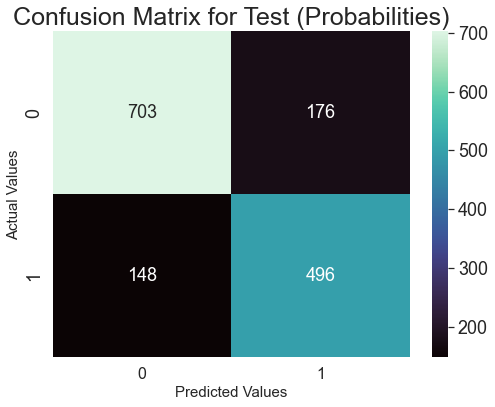

In [34]:
stacking.fit(X_train_tfid, y_train)
y_pred=stacking.predict_proba(X_test_tfid)[:,1]
plt.figure(figsize=(8,6))
cm=confusion_matrix(y_test,np.where(y_pred>.36,1,0))
sns.heatmap(cm,cmap='mako',fmt='.4g',annot=True, annot_kws={'fontsize':18})
plt.title('Confusion Matrix for Test (Probabilities)', fontsize=25);
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Actual Values', fontsize=15);
plt.show()